<b><center><font size = +3.5> Text Based Suicide Risk Detection Model for Mental Health Chatbots </font></center></b>

Author: Roshni Janakiraman

---

<u><center><h1> Notebook #1 : Introduction and Data Preparation </h1></center></u>

# &nbsp;&nbsp;&nbsp;&nbsp; I. &nbsp;&nbsp; Business Case

## Business Objective & Stakeholders
To provide a suicide risk detection model for mental health chatbot companies (e.g. [Pyx](https://www.pyxhealth.com/how-it-works/), [WoeBot](https://woebothealth.com/)

## Business Understanding


* There is an increasing need for <u>accessible and affordable</u> mental health care services, given the rising rates of mental illness and the growing shortage of mental health professionals in the United States [over recent years](https://www.npr.org/2022/10/10/1127889101/the-mental-health-crisis-and-shortage-of-providers-is-creating-big-debt-for-amer).

* The growing [Mental Health AI market](https://www.researchandmarkets.com/reports/5689466/ai-in-mental-health-global-market-outlook) has played a crucial role in filling this gap, by providing intelligent chatbots that can provide mental health support on-demand.
* [Over 40% of Americans](https://psychnews.psychiatryonline.org/doi/10.1176/appi.pn.2022.05.4.50) exclusively use chatbot services over in-person therapy, and most report [satisfaction](https://dl.acm.org/doi/fullHtml/10.1145/3453175) with these services.
    
* However, mental health chatbots are limited in their abilities.
* There are populations for whom mental health chatbots are not yet able to provide suitable care, such as **clients at risk for suicide.**
* Unconstrained chatbots have been shown to ignore and even encourage [self-harm and suicide](https://towardsdatascience.com/unconstrained-chatbots-condone-self-harm-e962509be2fa).

## Problem
* It is essential for mental health chatbots to be able to detect suicide risk and respond appropriately, given [5% of the US population reported experiencing suicidal thoughts](https://www.cdc.gov/mmwr/volumes/71/ss/ss7101a1.htm)
    1. Serious [legal and ethical ramifications](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8521996/#B17) of failing to respond properly to suicide risk
    2. This will allow mental health companies to better implement their [safeguards for high-risk clients](https://laist.com/news/health/therapy-by-chatbot-the-promise-and-challenges-in-using-ai-for-mental-health)
    3. A model that can detect suicide risk will **increase the efficiency of care** of mental health chatbots 

## Project Goals:

To create a model to classify individuals as **at suicide risk** or **not at suicide risk** based on a text analysis of their messages, using the following features: *word relevance*, *sentiment analysis*, and *emotion detection*

### 1. High Accuracy Rate
* Model should accurately classify text as indicative of suicide risk vs. non risk

### 2. High Recall Rate: Minimize *False Negatives*
* False Negative are failing to detect suicide risk in clients who *actually are* at risk
* False negative classifications are *dangerous*, since clients who need intervention would not get the support they need.

### 3. Quick Run Time 
* Model should generate predictions from unseen text *efficiently*, so that it can be deployed to work *in real time* with the mental health chatbot

---

# &nbsp;&nbsp;&nbsp;&nbsp; II. &nbsp;&nbsp; Notebook Set-Up

In [1]:
'''Python Standard Packages'''
import json
import pickle
import re
import time

'''Anaconda standard packages'''
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import seaborn as sns

'''Third Party Packages'''
import contractions
from lingua import Language, LanguageDetectorBuilder
from ftlangdetect import detect
from nrclex import NRCLex
import regex
from spellchecker import SpellChecker
from textblob import TextBlob
from textblob import Word
from textacy import preprocessing as preproc
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
%precision %.3f
pd.set_option('display.float_format', '{:.2f}'.format)

tqdm.pandas()

---

# &nbsp;&nbsp; III. &nbsp;&nbsp; Data Understanding

## Data Source

*Suicide and Depression Dataset* from [Kaggle](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch)

* This dataset consists over **over 200,000** posts webscraped from Reddit between December 2008 - January 2021 using Pushshift API. Posts were collected from "r/SuicideWatch" and "r/Teenagers"

### Target: Suicide Risk Classification ("Class")

* **<u>Suicide Risk</u>**: text from "r/SuicideWatch," a forum that provides "peer support for anyone struggling with suicidal thoughts."
    
* **<u>No Suicide Risk</u>**: text from "r/Teenagers," a forum for "average teenager discussions"

## Dataset - Descriptives

* Dataset consists of only two columns: *raw, unclean* text and suicide risk classification (suicide vs. non-suicide)
* Original dataset is too large for GitHub -- can be downloaded [here](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch)

In [3]:
#  Loading in dataset and dropping unnecessary index column
df = pd.read_csv("../data/Suicide_Detection.csv").drop('Unnamed: 0', axis=1)

#  Viewing first 5 rows of df
print(len(df))
df.head()


232074


,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


### Class Descriptives

* 50/50 split between each class in dataset
* This is notable because [class imbalances present in most suicide-related datasets](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8370663/)

In [4]:
df['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

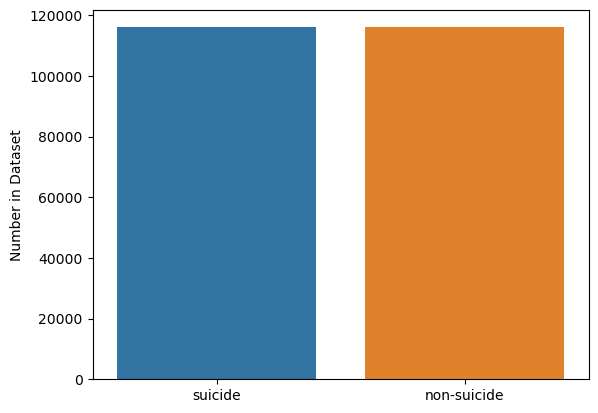

In [5]:
sns.barplot(x=df['class'].value_counts().index, y=df['class'].value_counts().values).set_ylabel('Number in Dataset');

# plt.savefig('./images/2-classdist.png', bbox_inches='tight', pad_inches=0.1, facecolor='white', transparent=False)

### Class Examples

In [6]:
print(f"Example of a suicide-risk post: \n\n {df['text'].loc[0]}")
print("\n")
print(f"Example of a non suicide-risk post: \n\n {df['text'].loc[1]}")

Example of a suicide-risk post: 

 Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.


Example of a non suicide-risk post: 

 Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it


## Dataset - Features of Interest 

Features of Interest that I will derive from text:
1. **Relevant Keywords:** determined by Term Frequency-Inverse Document Frequency calculation
2. **Sentiment Analysis:** rating the positivity, neutrality & negativity of sentences using *VADER Sentiment*
3. **Emotion Detection:** determining emotions indicated in text by calculating frequency of words associated with [eight primary emotions](uvm.edu/~mjk/013%20Intro%20to%20Wildlife%20Tracking/Plutchik's%20Wheel%20of%20Emotions%20-%202017%20Update%20_%20Six%20Seconds.pdf) using *NRCLex*

## Data Quality

### Notable strengths about current dataset:
1. **Large Sample Size** - hard to find mental health data of this size, especially with confidentiality constraints
2. **Equal Representation of Suicide Risk vs. Non-Risk class**

### Notable weaknesses:
1. Raw text needs *a lot* of cleaning -- lots of misspellings, unidentifiable characters, inconsistent spacing
    * Even with intensive cleaning techniques, I could not completely clean the data.
    * Trade-off between clean data and keeping authenticity of the data: for example, running a spellcheck altered the meaning of many sentences, so was ultimately not feasible.
2. Control group being r/teenagers -- in future studies, would be better to use a group more indicative of mental health support seekers
3. Spam Posts
    * Many spam posts in the dataset are formatted well enough to avoid spam filters, making it difficult to detect & delete them

---

# &nbsp;&nbsp; IV. &nbsp;&nbsp; Data Preparation

## A. &nbsp; Text Cleaning Steps

### 1. Simple Spam Remover

In [7]:
def char_counter(string):
    charCount = {"alnum": 0, "not_alnum": 0}
    accepted = " '"
    for char in string:
        if char.isalnum() or char in accepted:
            charCount["alnum"] += 1
        else:
            charCount["not_alnum"] += 1
    if charCount["not_alnum"] > charCount["alnum"]:
        return 0
    else:
        return string

In [8]:
before = len(df)

df["text_trial"] = df["text"].apply(lambda x: char_counter(x))
df = df[df["text_trial"] != 0]
df = df.drop(["text_trial"], axis=1)

after = len(df)

print(f"CharCounter Removed {before - after} spam data points")

CharCounter Removed 767 spam data points


In [9]:
df['text'].isna()

0         False
1         False
2         False
3         False
4         False
          ...  
232069    False
232070    False
232071    False
232072    False
232073    False
Name: text, Length: 231307, dtype: bool

### 2. Removing HTML tags, usernames (u/name), website urls, and numbers

In [10]:
""" TweetTokenizer will isolate HTML characters, easier to remove """

twtokenizer = TweetTokenizer()
df['text'] = df['text'].apply(lambda x: " ".join(twtokenizer.tokenize(x)))

In [11]:
def special_char_remover(row):
    patterns = r'|'.join(map(r'(?:{})'.format,
                             (r"\n&\S+", r"\n", r"&lt", r"&gt",
                              r"u/\S+", r"ww\S+", r"htt\S+",
                              r"\d\S+", r"\d+")))
    row = re.sub(patterns, '', row)
    str_en = row.encode("ascii", "ignore")
    str_de = str_en.decode()
    return str_de


df["text"] = df["text"].apply(lambda x: special_char_remover(x))

### 3. Expanding Contractions

In [12]:
df['text'] = df['text'].apply(lambda x: contractions.fix(x))

### 4. Removing Non-English Posts

In [13]:
detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()

In [14]:
def quick_detect(row):
    word_dict = detect(text=row)
    lang_tuple = (word_dict['lang'], word_dict['score'])
    return lang_tuple

In [15]:
quick_detect("I became paranoid that the school of jellyfish was spying on me.")

('en', 1.000)

In [16]:
quick_detect("I feel so silly right now because I did not even think about them being busy because of the \
Super Bowl. I probably should not have gotten so mad at them.")

('en', 0.989)

In [17]:
df['lang_tuple'] = df['text'].progress_apply(lambda row: quick_detect(row))

100%|██████████| 231307/231307 [00:05<00:00, 43213.56it/s]


In [18]:
df['ft_lang'] = df['lang_tuple'].apply(lambda x: x[0])
df['ft_conf'] = df['lang_tuple'].apply(lambda x: x[1])
df.drop('lang_tuple', axis=1, inplace=True)

In [19]:
noten_df = df[df['ft_lang']!= 'en'].sort_values(by='ft_conf', ascending=False)

In [20]:
not_en_index = list(noten_df[noten_df['ft_conf']>0.90].index)

In [21]:
# Dropping all values from df and noten_df where != 'en' and ft_conf > 0.90

noten_df.drop(not_en_index, inplace=True)
df.drop(not_en_index, inplace=True)

In [22]:
print(f"So far, {231307 - len(df)} non-english rows were dropped")

So far, 104 non-english rows were dropped


In [23]:
# Verifying rest with Lingua Detect:

In [24]:
def lingua_detection(row):
    if detector.detect_language_of(row) == Language.ENGLISH:
        return 1
    else:
        return 0

In [25]:
noten_df['lingua_is_en'] = noten_df['text'].progress_map(lambda x: lingua_detection(x))

100%|██████████| 1494/1494 [07:34<00:00,  3.28it/s]


In [26]:
not_en_index = list(noten_df[noten_df['lingua_is_en']==0].index)

noten_df.drop(not_en_index, inplace=True)
df.drop(not_en_index, inplace=True)

In [27]:
print(f"So far, {231307 - len(df)} non-english rows were dropped")

So far, 641 non-english rows were dropped


In [28]:
low_conf_english_df = df[df['ft_conf']<0.5]

In [29]:
lc_en_df=low_conf_english_df[low_conf_english_df['ft_lang']=='en'].copy()

In [30]:
lc_en_df['lingua_is_en'] = lc_en_df['text'].progress_map(lambda x: lingua_detection(x))

100%|██████████| 2886/2886 [14:09<00:00,  3.40it/s] 


In [31]:
not_en_index = lc_en_df[lc_en_df['lingua_is_en']==0].index

df.drop(not_en_index, inplace=True)
lc_en_df.drop(not_en_index, inplace=True)

In [32]:
print(f"{231307 - len(df)} non-english rows were dropped")

1235 non-english rows were dropped


### 5. Textacy Pre-Processing Pipline

In [33]:
# Timed Output: Takes 60 seconds to run

start = time.time()

pipe = preproc.make_pipeline(preproc.normalize.hyphenated_words,
                             preproc.normalize.quotation_marks,
                             preproc.normalize.unicode,
                             preproc.remove.accents,
                             preproc.remove.brackets,
                             preproc.remove.html_tags,
                             preproc.remove.punctuation,
                             preproc.normalize.whitespace)

df["text"] = df["text"].apply(lambda x: pipe(x))

end = time.time()
print(f'Time Taken: {end-start:.1f} seconds')

Time Taken: 44.7 seconds


### 6. Caps Processing Tasks + Lowercase All

In [34]:
ect_ther = list((df["text"].apply
                 (lambda x: re.findall(r" ECT ", x)).sort_values
                 (ascending=False)[:72].index))
ect_ther.extend([12935, 181494, 21986, 189017, 49323, 78657, 205774])
for index in ect_ther:
    df['text'][index] = re.sub(r'\Wect\W', r' electroconvulsive therapy ', df['text'][index], flags=re.A | re.I | re.S)

/var/folders/vn/0fdnf_cd0bsfss0cmbntv5s40000gn/T/ipykernel_31921/897260948.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][index] = re.sub(r'\Wect\W', r' electroconvulsive therapy ', df['text'][index], flags=re.A | re.I | re.S)


In [35]:
def caps_process(row):
    row = re.sub(r"(?<![A-Z\W])(?=[A-Z])", " ", row)
    row = re.sub(r" ect ", r" etc ", row)
    return row.lower()

In [36]:
df['text'] = df['text'].apply(lambda x: caps_process(x))

### 7. Noise Correction

In [37]:
def noise_corr(row):

    #  Prefix Fixing
    row = re.sub(r" (anti) (\S+) ", r" \1\2 ", row)
    row = re.sub(r" (mc) (\S+) ", r" \1\2 ", row)

    #  Removing filler words
    row = re.sub(r"fill\S+", "", row)
    row = re.sub(r"zz\S+", "", row)

    #  Remove duplicated words from row
    row = regex.sub(r'(?<= |^)(\S+)(?: \1){2,}(?= |$)', r'\1 \1', row)

    #  Remove all repeating characters > 2
    row = re.sub(r'(.)\1{2,}', r'\1', row)

    #  Correct cases of tldr being separated
    row = re.sub(r" tl dr ", r" tldr ", row)

    #  Make sure all chars are alnum
    for word in row.split():
        if word.isalnum():
            continue
        else:
            for char in word:
                if not char.isalnum():
                    word = word.replace(char, '')

    #  Return row with normalized whitespace
    return preproc.normalize.whitespace(row)

In [38]:
df['text'] = df['text'].progress_apply(lambda x: noise_corr(x))

100%|██████████| 230072/230072 [00:30<00:00, 7485.65it/s]


### 8. Spelling Correction

* While I could not completely clean all misspelled words, I did change the most common errors
    * Applying a spellchecker to the entire DF took a lot of computational power and led to significant meaning changes, which would be worse for the current analysis than spelling errors. 
    * This method ended up being the best compromise.
* In the "Testing SpellChecker" section of scratch_notebook, you can see my full process for finding and changing spelling errors.

* To simplify this notebook, I created imports with my changes & ran them with the functions below:

In [39]:
spell = SpellChecker()
with open('../cleaning_dictionaries/single_token_list.json', 'r') as f:
    single_token_list = json.load(f)
with open('../cleaning_dictionaries/correction_dictionary.json', 'r') as file:
    correction_dictionary = json.load(file)

In [40]:
""" Code to fix typos where i is appended to words """

index_check_wordis = list(df['text'][df['text'].apply(
    lambda row:len(re.findall(r"\b\S+i\b", row))) != 0].index)

for index in index_check_wordis:
    row = df['text'][index]
    for word in re.findall(r"\b\S+i\b", row):
        if spell.known([word]):
            continue

        tester = word[:-1]
        if len(spell.known([tester])) == 1:
            row = re.sub(word, tester + " i", row)
            df['text'][index] = row
        else:
            row = re.sub(word, '', row)
            df['text'][index] = row

/var/folders/vn/0fdnf_cd0bsfss0cmbntv5s40000gn/T/ipykernel_31921/3917712090.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][index] = row
/var/folders/vn/0fdnf_cd0bsfss0cmbntv5s40000gn/T/ipykernel_31921/3917712090.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][index] = row


In [41]:
def single_token_remover(row_list, token_list):
    """Remove Tokens that are single characters"""

    for token in row_list:
        if token in token_list:
            row_list.remove(token)
            single_token_remover(row_list, single_token_list)
    return " ".join(row_list)

In [42]:
df["text"] = df["text"].progress_map(
    lambda x: single_token_remover(x.split(), single_token_list))

100%|██████████| 230072/230072 [01:25<00:00, 2683.95it/s]


In [43]:
def replace_words(row, dictionary):
    """ Replacement Dictionary """

    new_row = []
    for word in row.split():
        if word in dictionary.keys():
            new_row.append(dictionary[word])
        else:
            new_row.append(word)
    return (" ".join(new_row))

In [44]:
df["text"] = df["text"].progress_map(
    lambda x: replace_words(x, correction_dictionary))

100%|██████████| 230072/230072 [00:03<00:00, 71212.35it/s]


### 9. Drop Unnecessary Columns

In [46]:
df.drop(['ft_lang', 'ft_conf'], axis=1, inplace=True)

---

## B. &nbsp; Feature Engineering

* As rule-based algorithms, VADER and NRCLex can be run on the full df before the train-test split. 
    * This will reduce computational effort during modeling & allows for pre-modeling data exploration

### 1.&nbsp; Sentiment Analysis with [VADERSentiment](https://github.com/cjhutto/vaderSentiment)

* Rates positivity, negativity & neutrality of sentences -- scale of (0 - 1)
* Compound score = sum of positive, negative & neutral scores, normalized across VADER's known lexicon
    * Takes into account word placement in sentence and modifiers (see example below)
        * Many other text analyzers (including NRCLex) do not account for this!

#### VADERSentiment Example

In [47]:
sent = SentimentIntensityAnalyzer()

print(sent.polarity_scores("it was good to see them until they ruined \
everything by insulting me and making me feel horrible."))

{'neg': 0.367, 'neu': 0.524, 'pos': 0.109, 'compound': -0.7845}


#### Getting Vader Sentiment Scores and Joining to DF

In [48]:
def sentiment_analyzer(df):
    """ Analyzes df for sentiment scores and concatenates results """
    dictlist = []
    sia = SentimentIntensityAnalyzer()
    for i in df.index:
        polarity = sia.polarity_scores(df['text'][i])
        dictlist.append({'negative': polarity['neg'],
                         'neutral': polarity['neu'],
                         'positive': polarity['pos'],
                         'comp': polarity['compound']})

    sentdf = pd.DataFrame(dictlist, index=df.index)
    df = df.join(sentdf, rsuffix='sent')
    return df

In [49]:
start = time.time()
df = sentiment_analyzer(df)
end = time.time()
print(f'Time to run: {(end-start)//60:.0f} min and {(end-start)%60:.0f} seconds')

Time to run: 5 min and 0 seconds


In [50]:
df.describe()

,negative,neutral,positive,comp
count,230072.00,230072.00,230072.00,230072.00
mean,0.13,0.74,0.12,-0.16
std,0.10,0.12,0.10,0.71
min,0.00,0.00,0.00,-1.00
25%,0.06,0.67,0.06,-0.89
50%,0.13,0.74,0.11,-0.26
75%,0.19,0.81,0.17,0.53
max,1.00,1.00,1.00,1.00


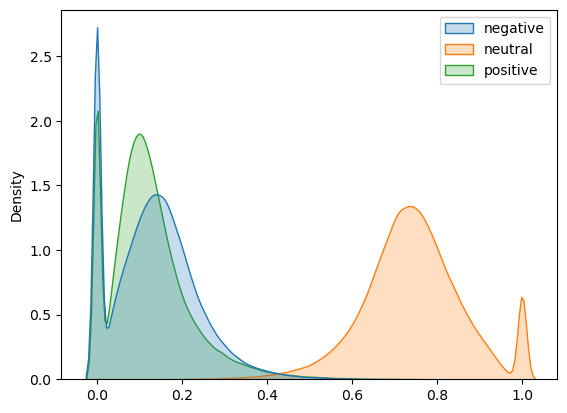

In [51]:
#  Distribution of Neg, Neutral & Positive ratings (scale: 0-1)
sns.kdeplot(df.iloc[:,2:5], fill=True);

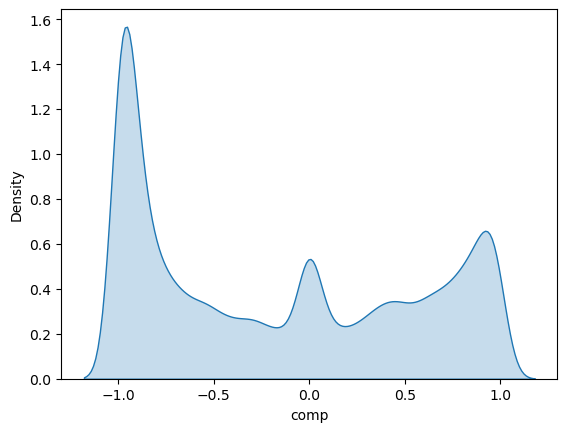

In [52]:
sns.kdeplot(df.iloc[:,-1], fill=True);

* Needs to be scaled. Data is very skewed. 
* Positive & Negative scores skewed right, but neutral scores skewed left.

Not much difference between clean and dirty text in VADER scores, so distribution may not be due to texts being too "sanitized." 

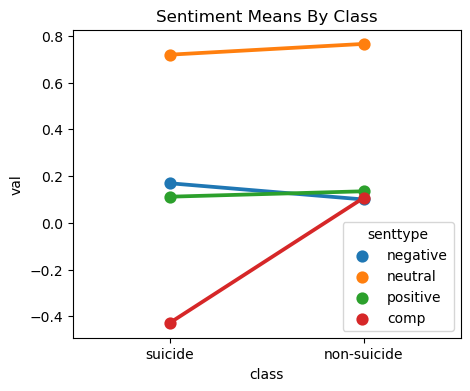

In [54]:
plotdf = df.drop(['text'], axis=1)
plotdf = pd.DataFrame(plotdf.set_index(['class']).unstack())
plotdf = plotdf.reset_index(level=[0,1])
plotdf.columns=['senttype','class','val']

plotdf
fig, ax = plt.subplots(figsize=(5,4))
sns.pointplot(plotdf, x='class', y='val', hue='senttype', ax=ax).set_title("Sentiment Means By Class");
# plt.savefig('./images/3-vader.png', bbox_inches='tight', pad_inches=0.1, facecolor='white', transparent=False)

* Graph indicates large difference in sentiment compound scores between suicide & nonsuicide; rest look insignificant

### 2.&nbsp; Emotion Detection Analysis with [NRCLex](https://github.com/metalcorebear/NRCLex)

* Based on [Plutchik's Wheel of Emotions](https://journals.plos.org/plosone/article/figure?id=10.1371/journal.pone.0256503.g004): counts emotion words of 8 "primary" emotions
* Word coded as emotion based on a large selection of [crowdsourced tweets](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm)
    * Word-based: not sensitive to context and sentence
        * Built in **tokenizing & lemmatizing** with *TextBlob*
* Returns count or frequency of emotion words used in a sentence
* **I will remove "positive, negative" ratings from NRCLex because VADER is better for Sentiment ratings**
    * Only use ratings of the 8 Emotion Words": Anger, Sadness, Disgust, Fear, Joy, Trust, Anticipation, Surprise

### NRCLex Example

In [55]:
sentence = NRCLex("it was good to see them until they ruined \
everything by insulting me and making me feel horrible.")


for key, val in sentence.affect_dict.items():
    print(f'{key}: {val}')    
print('\n')

pd.DataFrame([sentence.affect_frequencies, sentence.raw_emotion_scores], index=['affect_frequencies', 'raw_emotion_scores'])

good: ['anticipation', 'joy', 'positive', 'surprise', 'trust']
ruined: ['anger', 'disgust', 'fear', 'negative', 'sadness']
insulting: ['anger', 'disgust', 'fear', 'negative', 'sadness']
horrible: ['anger', 'disgust', 'fear', 'negative']




,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
affect_frequencies,0.16,0.16,0.00,0.05,0.05,0.05,0.16,0.11,0.16,0.05,0.05
raw_emotion_scores,3.00,3.00,NaN,1.00,1.00,1.00,3.00,2.00,3.00,1.00,1.00


### Getting Raw Emotion Scores and Joining to DF

In [56]:
emot_map = df['text'].progress_map(lambda x: NRCLex(x).raw_emotion_scores)

100%|██████████| 230072/230072 [01:11<00:00, 3222.02it/s]


In [57]:
lex_raw = pd.DataFrame([emot for emot in emot_map.values], index=emot_map.index)
lex_raw = lex_raw.drop(['positive', 'negative'], axis=1)
df = df.join(lex_raw, rsuffix='lex')
df = df.mask(df.isna(), 0)

### Data Exploration of Emotion Raw Scores

In [58]:
df.iloc[:,6:].describe()

,anger,disgust,fear,sadness,anticipation,joy,surprise,trust
count,230072.00,230072.00,230072.00,230072.00,230072.00,230072.00,230072.00,230072.00
mean,2.77,2.13,3.47,3.87,3.10,2.45,1.35,3.44
std,4.81,3.86,5.88,6.37,5.51,4.57,2.94,6.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,1.00,2.00,1.00,1.00,0.00,2.00
75%,4.00,3.00,4.00,5.00,4.00,3.00,2.00,4.00
max,350.00,350.00,349.00,349.00,421.00,367.00,342.00,343.00


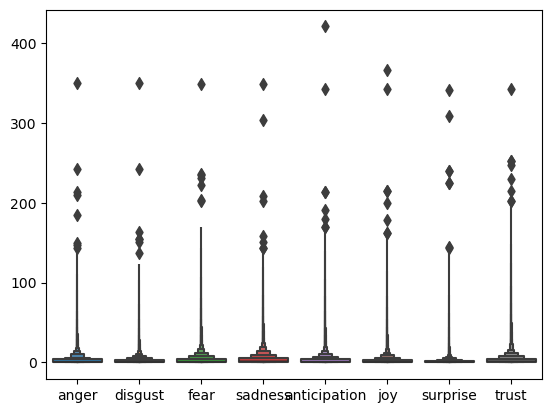

In [59]:
#  Distribution of Emotions
lex = df.iloc[:,6:]
sns.boxenplot(lex);

In [60]:
lex.quantile(.80)

anger          4.00
disgust        3.00
fear           6.00
sadness        6.00
anticipation   5.00
joy            4.00
surprise       2.00
trust          5.00
Name: 0.8, dtype: float64

* Heavy outliers! Needs to be scaled, possibly need to remove outliers.
* boxenplot when values capped largest percentile values: 95th (15), 5 (80) :

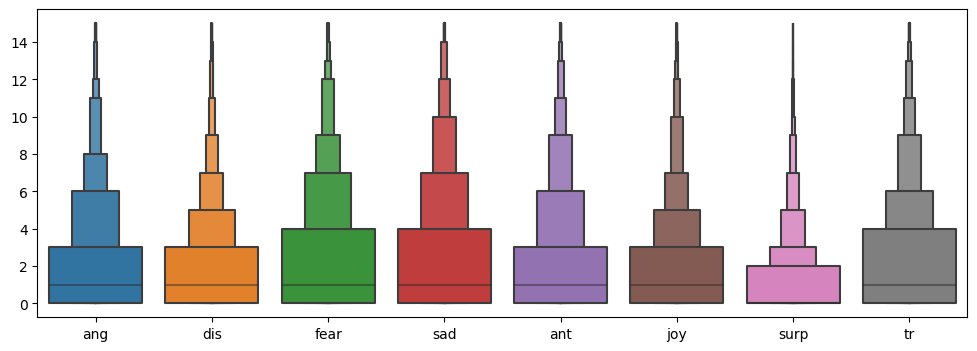

In [61]:
fig, ax = plt.subplots(figsize=(12,4))

sns.boxenplot(lex.mask(lex > 15, np.nan), ax=ax).set_xticklabels(['ang','dis','fear','sad','ant','joy','surp','tr']);

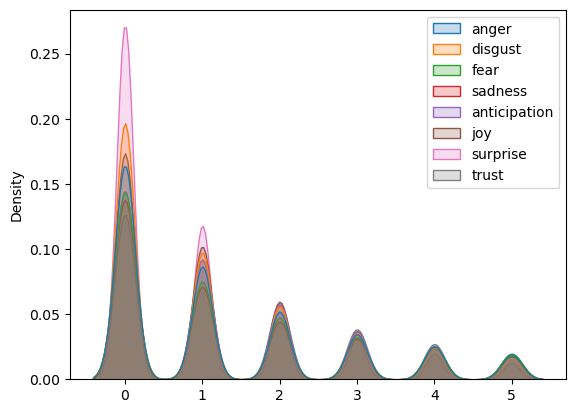

In [62]:
# KDE plot when capped at 80th percentile (x < 5):
sns.kdeplot(lex.mask(lex > 5, np.nan), fill=True);

In [63]:
df.pivot_table(values=['anger','disgust', 'fear', 'sadness', 
            'anticipation', 'joy', 'surprise', 'trust'], 
            index='class', aggfunc=np.mean)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
class,,,,,,,,
non-suicide,0.96,1.33,0.82,1.03,1.23,1.05,0.65,1.72
suicide,4.57,4.84,3.42,5.88,3.65,6.65,2.05,5.14


In [64]:
df.pivot_table(values=['anger','disgust', 'fear', 'sadness', 
            'anticipation', 'joy', 'surprise', 'trust'], 
            index='class', aggfunc=max)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
class,,,,,,,,
non-suicide,242.00,421.00,242.00,223.00,367.00,159.00,342.00,343.00
suicide,350.00,191.00,350.00,349.00,179.00,349.00,77.00,248.00


* Mean and Median of *all* emotions greater for suicide risk posts than non-suicide posts
* Max val of positive emotions higher for non-suicide group, but max val for negative emotions higher for suicide group

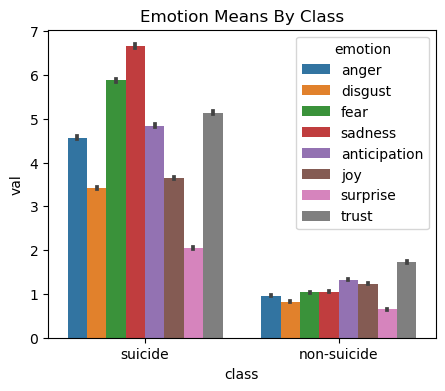

In [65]:
eplotdf = df.drop(['text', 'negative', 'neutral', 'positive', 'comp'], axis=1)
eplotdf = pd.DataFrame(eplotdf.set_index(['class']).unstack())
eplotdf = eplotdf.reset_index(level=[0,1])
eplotdf.columns=['emotion','class','val']

fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(eplotdf, x='class', y='val', hue='emotion').set_title("Emotion Means By Class");

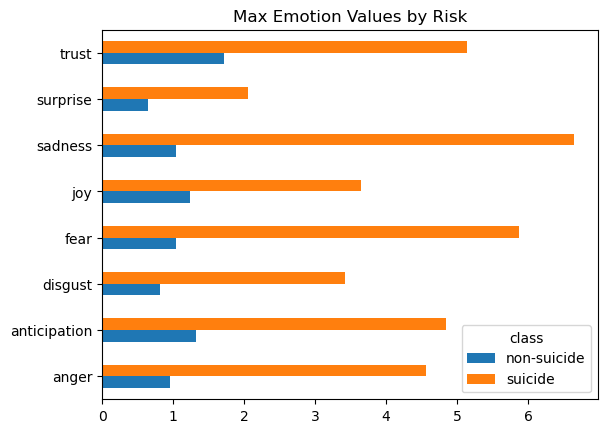

In [66]:
plotdf = df.pivot_table(values=['anger','disgust', 'fear', 'sadness', 
            'anticipation', 'joy', 'surprise', 'trust'], 
            index='class', aggfunc=np.mean)

plotdf.T.plot(kind='barh').set_title("Max Emotion Values by Risk");
# plt.savefig('./images/2-classdist.png', bbox_inches='tight', pad_inches=0.1, facecolor='white', transparent=False)

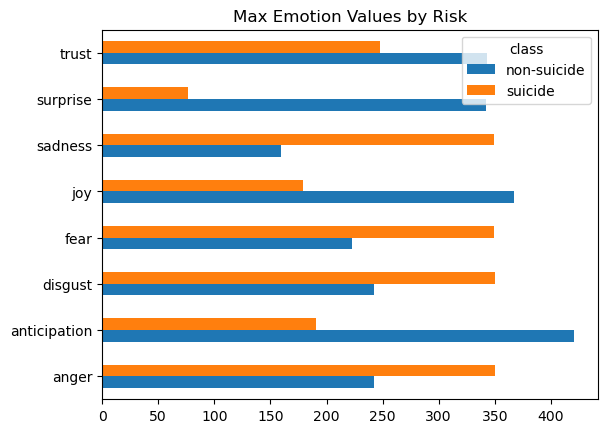

In [67]:
plotdf = df.pivot_table(values=['anger','disgust', 'fear', 'sadness', 
            'anticipation', 'joy', 'surprise', 'trust'], 
            index='class', aggfunc=max)

plotdf.T.plot(kind='barh').set_title("Max Emotion Values by Risk");
# plt.savefig('./images/2-classdist.png', bbox_inches='tight', pad_inches=0.1, facecolor='white', transparent=False)

---

### 3. &nbsp; Heat Map of Emotion & Sentiment Scores

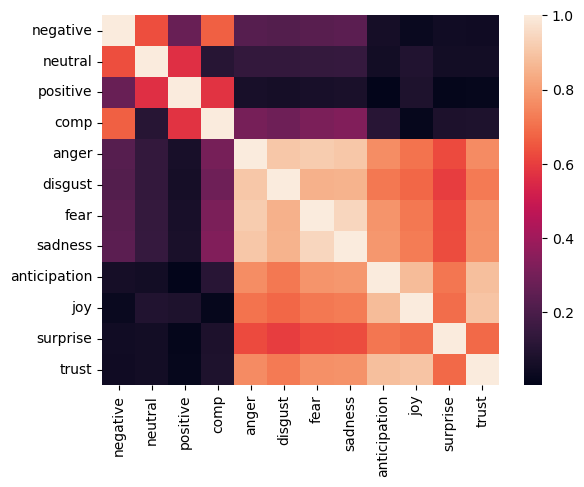

In [68]:
sns.heatmap(abs(df.iloc[:,2:].corr()));

* The emotion components seem to be heavily related to one another -- might not represent 8 separate components
* Sentiment components are more distinct from one another, but still correlated
* Low correlation between emotion & sentiment components

Next steps:
* Might be worth doing a PCA analysis with emotion components and reducing into fewer dimensions

---

## C. &nbsp; Final Dataframe Preparation

### 1. Lemmatize + Tokenize text with TextBlob

* Using same Lemmatizer as is in-built in NRCLex (TextBlob)
* Tokenize + rejoin tokens with space since TFIDF has built-in space tokenizer
* Store as df[lem], separate from df[text], in case need to re-run sentiment/emotion analysis 

In [69]:
## Warning: Take ~12 min to run

start = time.time()

df['tags'] = df['text'].progress_map(lambda x: TextBlob(x).tags)

end = time.time()

print(f"Time to run:{end-start}.")

100%|██████████| 230072/230072 [11:07<00:00, 344.79it/s]


Time to run:667.2844219207764.


In [70]:
df['tag_tokens'] = df['tags'].apply(lambda taglist: [(tag[0], tag[1][0].lower()) for tag in taglist])

In [71]:
acceptedtags = ['a', 'n', 'v', 'r']

In [72]:
def lemmatize_by_tag_tokens(row):

    new_row = []

    for tag in row:
        if tag[1] in acceptedtags:
            new_row.append(tag[0].lemmatize(tag[1]))
        else:
            if tag[1] == 'j':
                new_row.append(tag[0].lemmatize('a'))
            else:
                new_row.append(tag[0])
    return new_row

In [73]:
df['lem'] = df['tag_tokens'].apply(lambda x: lemmatize_by_tag_tokens(x))

In [74]:
df.drop(['tags', 'tag_tokens'], axis=1, inplace=True)

### 2. Remove Stopwords

For TF-IDF analysis, remove stopwords:

In [75]:
stop = stopwords.words('english')

df['lem_nostop'] = df['lem'].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))

In [79]:
df.drop(['text','lem'], axis=1, inplace=True)

### 3. Convert Target to Binary & Format Columns

In [80]:
df['target'] = df['class'].replace({'suicide':1, 'non-suicide':0})
df.drop('class',axis=1,inplace=True)

### 4. Rename and Reorganize Columns

In [81]:
df2 = df.copy()

In [82]:
df

,negative,neutral,positive,comp,anger,disgust,fear,sadness,anticipation,joy,surprise,trust,lem_nostop,target
0,0.19,0.73,0.07,-0.95,8.00,4.00,8.00,6.00,7.00,5.00,5.00,5.00,ex wife threaten suicide recently leave wife g...,1
1,0.04,0.76,0.21,0.72,0.00,1.00,0.00,0.00,2.00,1.00,1.00,2.00,weird get affect compliment come someone know ...,0
2,0.26,0.67,0.08,-0.70,2.00,2.00,2.00,1.00,2.00,2.00,1.00,3.00,finally almost never hear bad year ever swear ...,0
3,0.29,0.40,0.31,0.11,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,need help help cry hard,1
4,0.19,0.73,0.08,-1.00,18.00,10.00,27.00,26.00,20.00,6.00,5.00,9.00,lose hello name adam struggle year afraid past...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232069,0.08,0.92,0.00,-0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,like rock go get anything go,0
232070,0.09,0.77,0.15,0.34,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,tell many friend lonely everything deprive pre...,0
232071,0.00,0.84,0.16,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,pee probably taste like salty tea someone drin...,0
232072,0.18,0.72,0.10,-0.99,9.00,6.00,7.00,10.00,3.00,1.00,1.00,3.00,usual stuff find post sympathy pity know far b...,1


In [85]:
df.columns

Index(['negative', 'neutral', 'positive', 'comp', 'anger', 'disgust', 'fear',
       'sadness', 'anticipation', 'joy', 'surprise', 'trust', 'lem_nostop',
       'target'],
      dtype='object')

In [93]:
collist = ['neg', 'neu', 'pos', 'compound', 'anger', 'disgust', 'fear',
           'sadness', 'anticipation', 'joy', 'surprise', 'trust',
           'text', 'target']
df.columns = collist
df

,neg,neu,pos,compound,anger,disgust,fear,sadness,anticipation,joy,surprise,trust,text,target
0,0.19,0.73,0.07,-0.95,8.00,4.00,8.00,6.00,7.00,5.00,5.00,5.00,ex wife threaten suicide recently leave wife g...,1
1,0.04,0.76,0.21,0.72,0.00,1.00,0.00,0.00,2.00,1.00,1.00,2.00,weird get affect compliment come someone know ...,0
2,0.26,0.67,0.08,-0.70,2.00,2.00,2.00,1.00,2.00,2.00,1.00,3.00,finally almost never hear bad year ever swear ...,0
3,0.29,0.40,0.31,0.11,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,need help help cry hard,1
4,0.19,0.73,0.08,-1.00,18.00,10.00,27.00,26.00,20.00,6.00,5.00,9.00,lose hello name adam struggle year afraid past...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232069,0.08,0.92,0.00,-0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,like rock go get anything go,0
232070,0.09,0.77,0.15,0.34,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,tell many friend lonely everything deprive pre...,0
232071,0.00,0.84,0.16,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,pee probably taste like salty tea someone drin...,0
232072,0.18,0.72,0.10,-0.99,9.00,6.00,7.00,10.00,3.00,1.00,1.00,3.00,usual stuff find post sympathy pity know far b...,1


In [94]:
orderedcols = ['target', 'text', 'neg', 'neu', 'pos', 'compound',
               'anger', 'disgust', 'fear', 'sadness',
               'anticipation', 'joy', 'surprise', 'trust']

In [95]:
len(orderedcols) == len(df.columns)

True

In [96]:
df = df[orderedcols]

In [97]:
df

,target,text,neg,neu,pos,compound,anger,disgust,fear,sadness,anticipation,joy,surprise,trust
0,1,ex wife threaten suicide recently leave wife g...,0.19,0.73,0.07,-0.95,8.00,4.00,8.00,6.00,7.00,5.00,5.00,5.00
1,0,weird get affect compliment come someone know ...,0.04,0.76,0.21,0.72,0.00,1.00,0.00,0.00,2.00,1.00,1.00,2.00
2,0,finally almost never hear bad year ever swear ...,0.26,0.67,0.08,-0.70,2.00,2.00,2.00,1.00,2.00,2.00,1.00,3.00
3,1,need help help cry hard,0.29,0.40,0.31,0.11,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
4,1,lose hello name adam struggle year afraid past...,0.19,0.73,0.08,-1.00,18.00,10.00,27.00,26.00,20.00,6.00,5.00,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232069,0,like rock go get anything go,0.08,0.92,0.00,-0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
232070,0,tell many friend lonely everything deprive pre...,0.09,0.77,0.15,0.34,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00
232071,0,pee probably taste like salty tea someone drin...,0.00,0.84,0.16,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
232072,1,usual stuff find post sympathy pity know far b...,0.18,0.72,0.10,-0.99,9.00,6.00,7.00,10.00,3.00,1.00,1.00,3.00


In [99]:
del df2

---

### 5. Convert to CSV/Pickle

In [100]:
df.to_csv('../fulldataclean.csv')

In [101]:
df.to_pickle('../fulldataclean.pkl')

In [102]:
df.to_pickle('./data/fulldataclean.tar.gz', compression='infer')

---

# Project Continued in Notebook #2

Notebook #2: [2-Modeling-and-Conclusions.ipynb]("./2-Modeling-and-Conclusions.ipynb")

---